In [1]:
import matplotlib
import matplotlib.pyplot as plt
import mrlattice.lattice as lat
import numpy as np

In [2]:
# this notebook requires mrlattice version:
VERSION = "0.1.4"

In [3]:
%run prepare_notebook.ipynb

The following names are now available:

<class '__main__.LatticeArrayPlotWidget'>
<class '__main__.SuperimposeLatticeArrayPlotWidget'>


In [4]:
%load_ext jupyter_spaces

In [5]:
# interactive plots in notebook
# %matplotlib notebook
# open external window with plot
# %matplotlib qt
# for saving widget state
%matplotlib inline

if "inline" in matplotlib.get_backend():
    plt.rcParams["figure.figsize"] = (14, 14)
else:
    plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

# Homogeneous Lattice

In previous notebooks we have regularly used plots of homogeneous lattices (where all cells are the same dimensions) for vairous explanations. We now want to properly introduce the generation of homogeneous lattices with HomogeneousLatticeArray. Although it is the simplest type of lattice, it is not possible to obtain homogeneous lattices from LatticeArray. It needs its own generation routine.


## Generating a homogeneous lattice

The code for generating the array in `homogeneous_fill` is simple. We get the values from the properties and fill the array with the same tuple. Then we overwrite `generate_array` to create the new homogeneous lattice instead of whatever it was doing before.

The constructor has a lot of changes too. It extends super, but after the call to super we delete the properties we don't need and the second scheme. We set the fixed number scheme as placebo to be still able to use LatticeArrayScheme and its integration with LatticeArray. This also automatically removes these options form the plot widget, as that LatticeArrayPlotWidget fetches available properties from the lattice instance it works on. We also change the description of the repurposed properties we still use.

We overwrite `update_properties` with only a single line that removes the `_array` attribute from the class' attributes list. Instead of calling `del` on the attribute we use pop on `__dict__`. This allows us to set a default return value if `_array` is not a member of HomogeneousLatticeArray instead of raising an AttributeError when trying to delete a non existent attribute. This line is the same as super. However, we leave out any other code from super that would update the properties based on the active scheme. So `update_properties` just resets the `.array` if it is already exists.

In [6]:
class HomogeneousLatticeArray(lat.generate.LatticeArray):
    """Generate homogeneous lattices."""
    
    def __init__(
        self,
        scale=None,  # coarse_steps
        space_width=None,  # buffer
        temp_width=None,  # repeat
    ):
        # scheme does not matter here, but needs to be set
        sc = lat.configure.LatticeArrayScheme.FIXED_NUMBER_SCHEME
        super().__init__(scheme=sc, coarse_steps=scale, buffer=space_width, repeat=temp_width)
        # remove irrelevant config params
        del self.PROPERTY_DESCRIPTIONS["finest_width"]
        del self._finest_width
        del self.PROPERTY_DESCRIPTIONS["borders_width"]
        del self._borders_width
        # before modifying a class vairable make a copy to instance
        self.scheme.SCHEME_DESCRIPTIONS = dict(self.scheme.SCHEME_DESCRIPTIONS)
        del self.scheme.SCHEME_DESCRIPTIONS[
            lat.configure.LatticeArrayScheme.FIXED_WIDTH_SCHEME
        ]
        # change descriptions to be meaningful for homogeneous lattices
        self.scheme.SCHEME_DESCRIPTIONS[sc] = "Has no Coarsening Regions"
        self.coarse_steps.description = r"Scale of Cells: $2^{scale}$ [in Units of Finest]"
        self.buffer.description = "Spacial Width [Number of Cells]"
        self.repeat.description = "Temporal Width [Number of Cells]"

    def homogeneous_fill(self):
        """Homogeneous lattice of coarsest resolution.

        This saves a lattice in `.array` with spacial width of `.buffer`
        times 2**`.coarse_steps` and temporal width of `.repeat`, where
        all cells are square. The result is a homogeneous lattice.
        """
        temp_width = 2 ** self.coarse_steps.value
        space_width = temp_width  # square cells
        self._array = np.empty(self.repeat.value * temp_width, dtype=object)
        self._array.fill(((temp_width, space_width, self.buffer.value),))
    
    def update_properties(self):
        # reset array if existing
        self.__dict__.pop("_array", None)
    
    def generate_array(self):
        # overwrite generate_array
        self.homogeneous_fill()

LatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Scale of Cells: $2^…

Output()

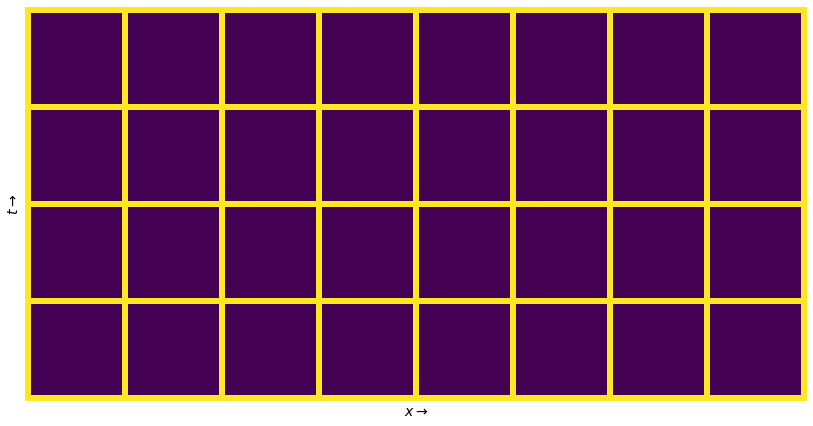

In [7]:
LatticeArrayPlotWidget(lattice=HomogeneousLatticeArray(scale=3, space_width=8, temp_width=4))

In [8]:
HomogeneousLatticeArray()

<HomogeneousLatticeArray(scheme=fixed_number, coarse_steps=1, buffer=1, repeat=1 at 0x7ff6d8d3b190>